In [1]:
# -*- coding: utf-8 -*-

import scipy.io
import numpy as np
import tensorflow as tf
import sklearn as sk
import matplotlib.pyplot as plt
import itertools
import random

from numba import cuda
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix

from tensorflow.keras.callbacks import  EarlyStopping

In [2]:
# tensorflow = 2.
# python = 3.6


seed = np.random.seed(777)

gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    
  try:
      
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
      
  except RuntimeError as e:
      
    print(e)


val_loss_all = []

test_loss_all = []
test_acc_all = []
test_pre_all = []
frr_all = []
far_all = []

conf_matrix_sco = []
test_pre_sco = []
test_rec_sco = []
test_spedi_sco = []
test_sensi_sco = []

class MyModelCheckpoint(tf.keras.callbacks.ModelCheckpoint):

    def __init__(self, *args, **kwargs):
        super(MyModelCheckpoint, self).__init__(*args, **kwargs)

    # redefine the save so it only activates after 100 epochs
    def on_epoch_end(self, epoch, logs=None):
        if epoch >= 1: super(MyModelCheckpoint, self).on_epoch_end(epoch, logs)

In [3]:
train_data = scipy.io.loadmat('../../datas/160hz/train_5day_160hz.mat', squeeze_me=True)['data']
test_data = scipy.io.loadmat('../../datas/160hz/test_6day_160hz(2).mat', squeeze_me=True)['data']

# sub 수
sub_cnt = train_data.shape[0]

# 3sec 데이터 크기
data_size = 480

# 1명당 3초 데이터 개수
train_data_cnt = 1052
test_data_cnt = 211

# 3sec 480(= 160*3) 크기로 데이터 길이 설정
train_cut_size = 504960 # 480*1052 = 504960
test_cut_size = 101280 # 480*211 = 101280

# 3sec 데이터 길이 자르기
# train: 504,960 / test: 101,280
train_data = train_data[:,0:train_cut_size,:]
test_data = test_data[:,0:test_cut_size,:]

# flatten(): 3D -> 1D / reshape(-1,1): -1 마지막 인덱스
train_flatten = train_data.flatten().reshape(-1,1)
test_flatten = test_data.flatten().reshape(-1,1)

# StandardScaler(): train에 맞춰 표준화
data_scaler = StandardScaler()
    
data_scaler.fit(train_flatten)
train_scaler = data_scaler.transform(train_flatten)
test_scaler = data_scaler.transform(test_flatten)
    
# train, test 데이터 reshape
train_data = train_scaler.reshape(train_data_cnt * sub_cnt, data_size, 2) 
test_data = test_scaler.reshape(test_data_cnt * sub_cnt, data_size, 2)

#train data를 sub:other=1:1로 만들기 위해서 각 sub 추출
train_data_each = []
for i in range(sub_cnt):
    train_data_each.insert(i, train_data[i*train_data_cnt:(i+1)*train_data_cnt, :, :])
print(np.shape(train_data_each))

#test data를 sub:other=1:3로 만들기 위해서 각 sub 추출
test_data_each = []
for i in range(sub_cnt):
    test_data_each.insert(i, test_data[i*test_data_cnt:(i+1)*test_data_cnt, :, :])
print(np.shape(test_data_each))

(11, 1052, 480, 2)
(11, 211, 480, 2)


In [4]:
# sub number
sub_num = 8

#1 to 3 비율로 설정
ratio = 3

train_data_n = train_data_each[sub_num]
test_data_n = test_data_each[sub_num]

# train data를 sub:other = 1:3으로 만들기
# 3초 덩어리 개수 1052 : 3156
# => 315 * 4 + 316 * 6 = 1260 + 1896 = 3156

# test data를 sub:other = 1:3로 만들기
# 3초 덩어리 개수 211 : 633
# 63 * 7 + 64 * 3 = 633

cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 4:
        cnt = cnt + 1
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 315)), axis = 0)
    elif j != sub_num and cnt >= 4:
        train_data_n = np.append(train_data_n, np.array(random.sample(list(train_data_each[j]), 316)), axis = 0)
#     print("train_data_n.shape")
#     print(train_data_n.shape)
#     print("train_data_n")
#     print(train_data_n)
        
cnt = 0
for j in range(sub_cnt):
    if j != sub_num and cnt < 7:
        cnt = cnt + 1
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 63)), axis = 0)
    elif j != sub_num and cnt >= 7:
        test_data_n = np.append(test_data_n, np.array(random.sample(list(test_data_each[j]), 64)), axis = 0)
        
        
        
train_label = np.zeros(train_data_cnt*(ratio+1))
test_label = np.zeros(test_data_cnt*(ratio+1))

for j in range(len(train_label)):
    if (j < train_data_cnt):
        train_label[j] = 1

for j in range(len(test_label)):
    if (j < test_data_cnt):
        test_label[j] = 1
        
train_data_shuffled, train_label_shuffled = sk.utils.shuffle(train_data_n, train_label, random_state = 0)

val_data_set = train_data_shuffled[:train_data_cnt]
train_data_set = train_data_shuffled[train_data_cnt:]

val_label_set = train_label_shuffled[:train_data_cnt]
train_label_set = train_label_shuffled[train_data_cnt:]
  

Epoch 1/200
99/99 [==============================] - 6s 56ms/step - loss: 0.5645 - accuracy: 0.7544 - val_loss: 0.5488 - val_accuracy: 0.7367
Epoch 2/200
98/99 [============================>.] - ETA: 0s - loss: 0.5044 - accuracy: 0.7656
Epoch 00002: val_loss improved from inf to 0.46166, saving model to best_model_9.h5
99/99 [==============================] - 5s 55ms/step - loss: 0.5041 - accuracy: 0.7658 - val_loss: 0.4617 - val_accuracy: 0.7956
Epoch 3/200
98/99 [============================>.] - ETA: 0s - loss: 0.4747 - accuracy: 0.7864
Epoch 00003: val_loss improved from 0.46166 to 0.43299, saving model to best_model_9.h5
99/99 [==============================] - 5s 56ms/step - loss: 0.4746 - accuracy: 0.7864 - val_loss: 0.4330 - val_accuracy: 0.8118
Epoch 4/200
98/99 [============================>.] - ETA: 0s - loss: 0.4548 - accuracy: 0.8074
Epoch 00004: val_loss improved from 0.43299 to 0.41208, saving model to best_model_9.h5
99/99 [==============================] - 6s 59ms/step

99/99 [==============================] - ETA: 0s - loss: 0.2903 - accuracy: 0.8736
Epoch 00029: val_loss did not improve from 0.26752
99/99 [==============================] - 6s 57ms/step - loss: 0.2903 - accuracy: 0.8736 - val_loss: 0.2785 - val_accuracy: 0.8774
Epoch 30/200
98/99 [============================>.] - ETA: 0s - loss: 0.2881 - accuracy: 0.8731
Epoch 00030: val_loss did not improve from 0.26752
99/99 [==============================] - 6s 62ms/step - loss: 0.2888 - accuracy: 0.8729 - val_loss: 0.3369 - val_accuracy: 0.8422
Epoch 31/200
99/99 [==============================] - ETA: 0s - loss: 0.3055 - accuracy: 0.8704
Epoch 00031: val_loss did not improve from 0.26752
99/99 [==============================] - 6s 60ms/step - loss: 0.3055 - accuracy: 0.8704 - val_loss: 0.2688 - val_accuracy: 0.8783
Epoch 32/200
98/99 [============================>.] - ETA: 0s - loss: 0.2850 - accuracy: 0.8788
Epoch 00032: val_loss did not improve from 0.26752
99/99 [============================

Epoch 58/200
98/99 [============================>.] - ETA: 0s - loss: 0.2636 - accuracy: 0.8846
Epoch 00058: val_loss did not improve from 0.23312
99/99 [==============================] - 6s 63ms/step - loss: 0.2627 - accuracy: 0.8853 - val_loss: 0.2629 - val_accuracy: 0.8897
Epoch 59/200
99/99 [==============================] - ETA: 0s - loss: 0.2459 - accuracy: 0.8948
Epoch 00059: val_loss did not improve from 0.23312
99/99 [==============================] - 6s 61ms/step - loss: 0.2459 - accuracy: 0.8948 - val_loss: 0.2439 - val_accuracy: 0.9002
Epoch 60/200
99/99 [==============================] - ETA: 0s - loss: 0.2495 - accuracy: 0.8932
Epoch 00060: val_loss did not improve from 0.23312
99/99 [==============================] - 6s 58ms/step - loss: 0.2495 - accuracy: 0.8932 - val_loss: 0.2429 - val_accuracy: 0.8935
Epoch 61/200
98/99 [============================>.] - ETA: 0s - loss: 0.2519 - accuracy: 0.8852
Epoch 00061: val_loss improved from 0.23312 to 0.22549, saving model to b

99/99 [==============================] - ETA: 0s - loss: 0.2403 - accuracy: 0.8939
Epoch 00087: val_loss did not improve from 0.20824
99/99 [==============================] - 6s 59ms/step - loss: 0.2403 - accuracy: 0.8939 - val_loss: 0.2359 - val_accuracy: 0.9087
Epoch 88/200
98/99 [============================>.] - ETA: 0s - loss: 0.2503 - accuracy: 0.8957
Epoch 00088: val_loss did not improve from 0.20824
99/99 [==============================] - 6s 59ms/step - loss: 0.2495 - accuracy: 0.8961 - val_loss: 0.2195 - val_accuracy: 0.9116
Epoch 89/200
98/99 [============================>.] - ETA: 0s - loss: 0.2332 - accuracy: 0.8983
Epoch 00089: val_loss did not improve from 0.20824
99/99 [==============================] - 6s 61ms/step - loss: 0.2338 - accuracy: 0.8983 - val_loss: 0.2278 - val_accuracy: 0.9049
Epoch 90/200
98/99 [============================>.] - ETA: 0s - loss: 0.2181 - accuracy: 0.9062
Epoch 00090: val_loss did not improve from 0.20824
99/99 [============================

99/99 [==============================] - ETA: 0s - loss: 0.2060 - accuracy: 0.9135
Epoch 00116: val_loss did not improve from 0.20279
99/99 [==============================] - 5s 51ms/step - loss: 0.2060 - accuracy: 0.9135 - val_loss: 0.2051 - val_accuracy: 0.9049
Epoch 117/200
98/99 [============================>.] - ETA: 0s - loss: 0.2054 - accuracy: 0.9126
Epoch 00117: val_loss improved from 0.20279 to 0.19585, saving model to best_model_9.h5
99/99 [==============================] - 5s 52ms/step - loss: 0.2045 - accuracy: 0.9132 - val_loss: 0.1959 - val_accuracy: 0.9230
Epoch 118/200
99/99 [==============================] - ETA: 0s - loss: 0.2064 - accuracy: 0.9138
Epoch 00118: val_loss did not improve from 0.19585
99/99 [==============================] - 5s 51ms/step - loss: 0.2064 - accuracy: 0.9138 - val_loss: 0.2173 - val_accuracy: 0.8973
Epoch 119/200
99/99 [==============================] - ETA: 0s - loss: 0.2077 - accuracy: 0.9125
Epoch 00119: val_loss did not improve from 0.1

98/99 [============================>.] - ETA: 0s - loss: 0.2079 - accuracy: 0.9056
Epoch 00145: val_loss did not improve from 0.19229
99/99 [==============================] - 4s 45ms/step - loss: 0.2069 - accuracy: 0.9062 - val_loss: 0.2252 - val_accuracy: 0.8992
Epoch 146/200
99/99 [==============================] - ETA: 0s - loss: 0.1942 - accuracy: 0.9151
Epoch 00146: val_loss did not improve from 0.19229
99/99 [==============================] - 5s 46ms/step - loss: 0.1942 - accuracy: 0.9151 - val_loss: 0.1994 - val_accuracy: 0.9087
Epoch 147/200
98/99 [============================>.] - ETA: 0s - loss: 0.1958 - accuracy: 0.9193
Epoch 00147: val_loss improved from 0.19229 to 0.18978, saving model to best_model_9.h5
99/99 [==============================] - 4s 44ms/step - loss: 0.1952 - accuracy: 0.9198 - val_loss: 0.1898 - val_accuracy: 0.9183
Epoch 148/200
99/99 [==============================] - ETA: 0s - loss: 0.1851 - accuracy: 0.9246
Epoch 00148: val_loss did not improve from 0.1

99/99 [==============================] - ETA: 0s - loss: 0.1735 - accuracy: 0.9287
Epoch 00174: val_loss did not improve from 0.18603
99/99 [==============================] - 4s 36ms/step - loss: 0.1735 - accuracy: 0.9287 - val_loss: 0.2112 - val_accuracy: 0.9125
Epoch 175/200
99/99 [==============================] - ETA: 0s - loss: 0.1683 - accuracy: 0.9255
Epoch 00175: val_loss did not improve from 0.18603
99/99 [==============================] - 3s 35ms/step - loss: 0.1683 - accuracy: 0.9255 - val_loss: 0.1865 - val_accuracy: 0.9221
Epoch 176/200
99/99 [==============================] - ETA: 0s - loss: 0.1689 - accuracy: 0.9271
Epoch 00176: val_loss did not improve from 0.18603
99/99 [==============================] - 3s 35ms/step - loss: 0.1689 - accuracy: 0.9271 - val_loss: 0.2081 - val_accuracy: 0.9116
Epoch 177/200
99/99 [==============================] - ETA: 0s - loss: 0.1931 - accuracy: 0.9176
Epoch 00177: val_loss did not improve from 0.18603
99/99 [=========================

33/33 - 0s - loss: 0.1856 - accuracy: 0.9240
27/27 - 0s - loss: 0.1346 - accuracy: 0.9502


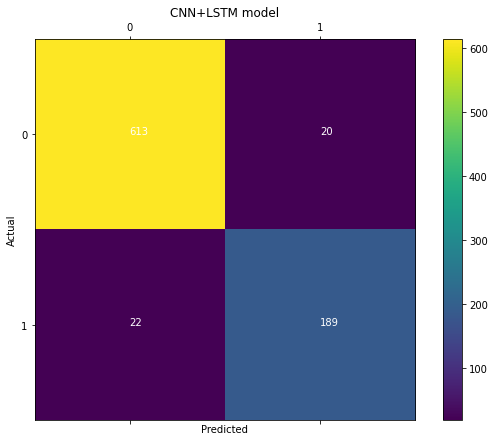

val_loss: 0.18562769889831543
test_loss: 0.1346316784620285
test_acc: 0.950236976146698
precision: 0.9043062200956937
recall: 0.8957345971563981
specificity 0.9684044233807267
sensitivity :  0.8957345971563981
far 0.0315955766192733
frr 0.10426540284360189


In [5]:
# model CNN-LSTM    
inputs = tf.keras.Input(shape = (480, 2))
conv_1 = tf.keras.layers.Conv1D(filters = 127, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(inputs)
max_1 = tf.keras.layers.MaxPool1D(3)(conv_1)
    
conv_2 = tf.keras.layers.Conv1D(filters = 20, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_1)
max_2 = tf.keras.layers.MaxPool1D(3)(conv_2)
    
# conv_3 = tf.keras.layers.Conv1D(filters = 47, kernel_size = 3, strides = 1, padding = 'same', activation = 'relu')(max_2)
# max_3 = tf.keras.layers.MaxPool1D(3)(conv_3)
    

D_out_1 = tf.keras.layers.Dropout(0.7477320947302286)(max_2)
    
    
lstm_1 = tf.keras.layers.LSTM(107)(D_out_1)
    
dense_1 = tf.keras.layers.Dense(29, activation = 'relu')(lstm_1)
# dense_2 = tf.keras.layers.Dense(34, activation = 'relu')(dense_1)
# dense_3 = tf.keras.layers.Dense(55, activation = 'relu')(dense_2)
dense_4 = tf.keras.layers.Dense(1, activation = 'sigmoid')(dense_1)
    
model = tf.keras.models.Model(inputs = inputs, outputs = dense_4)

# Adam
model.compile(loss = 'binary_crossentropy', optimizer = tf.keras.optimizers.Adam(0.0005091769886330065), metrics = ['accuracy'])
# SGD
# model.compile(loss= 'binary_crossentropy', optimizer= tf.keras.optimizers.SGD(learning_rate=0.06347691327304918, momentum=0.027904272142875237), metrics=['accuracy'])
    
# EarlyStopping 조기종료 및 모델 학습
early_stopping = tf.keras.callbacks.EarlyStopping(patience = 20)
check_point = MyModelCheckpoint('best_model_' + str(sub_num + 1) + '.h5', monitor = 'val_loss', mode = 'min', save_best_only = True, verbose = 1)

# EarlyStopping 사용
# hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [early_stopping, check_point])
# EarlyStopping 미사용
hist = model.fit(train_data_set, train_label_set, epochs = 200, batch_size = 32, validation_data = (val_data_set, val_label_set), callbacks = [check_point])
        
# model save .h5형식
model = tf.keras.models.load_model('best_model_' + str(sub_num + 1) + '.h5')
model.save('Binary_BOHB_' + str(sub_num + 1) + '.h5')
model.summary() 
        
val_loss, val_acc = model.evaluate(val_data_set, val_label_set, verbose = 2)

test_loss, test_acc = model.evaluate(test_data_n, test_label, verbose = 2)
test_pred = model.predict(test_data_n)
        
    
# 각 행은 1sec, 0.5 <= 자신, 0.5 > 타인
for i in range(len(test_pred)):
    if(test_pred[i] >= 0.5):
        test_pred[i] = 1
    
    else: 
        test_pred[i] = 0
    
    
val_loss_all.append(val_loss)
    
test_loss_all.append(test_loss)
test_acc_all.append(test_acc)
test_pre_all.append(test_pred)
    

conf_matrix = confusion_matrix(test_label, test_pred) 
conf_matrix_sco.append(conf_matrix)
    
conf_row = conf_matrix.sum(axis = 1)
conf_col = conf_matrix.sum(axis = 0)

precision = conf_matrix[1][1] / conf_col[1]
recall = conf_matrix[1][1] / conf_row[1]
specificity = conf_matrix[0][0] / conf_row[0]
sensitivity = conf_matrix[1][1] / conf_row[1]
frr = conf_matrix[1][0] / (conf_matrix[1][1]+conf_matrix[1][0])
far = conf_matrix[0][1] / (conf_matrix[0][1]+conf_matrix[0][0])
    
frr_all.append(frr)
far_all.append(far)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111)

cax = ax.matshow(conf_matrix)

fig.colorbar(cax)

for i, j in itertools.product(range(conf_matrix.shape[0]), range(conf_matrix.shape[1])):
    plt.text(j, i, conf_matrix[i, j], color="white")

plt.title('CNN+LSTM model')
plt.xlabel('Predicted')
plt.ylabel('Actual')

plt.show()
 
    
test_pre_sco.append(precision)
test_rec_sco.append(recall)
test_spedi_sco.append(specificity)
test_sensi_sco.append(sensitivity)
    
print('val_loss:', val_loss)
print('test_loss:', test_loss)
print('test_acc:', test_acc)
    
print('precision:', precision)
print('recall:', recall)
print('specificity', specificity)
print('sensitivity : ', sensitivity)
print('far', far)
print('frr', frr)